# Visualising the results

This is how to make a gif showing how the flow varies over time.

In [5]:
#imports:
import math
import pickle
import imageio
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.colorbar as cbar
from numba import jit
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from matplotlib.colors import ListedColormap
warnings.filterwarnings('ignore')
plt.style.use('seaborn-white')


# data - note terrain data is in a shapefile so need geopandas to unpack it

data = pd.read_csv('data/numerical_flow_data.csv', header=0, index_col=0, parse_dates=[0])
data=data.T
terrain = gpd.read_file('data/terrain/terrain.shp')
terrain.crs = {'init': 'espg3857'}
rain = pd.read_csv('data/edited_rain.csv', header=0, parse_dates=[0], index_col=0)  #inflow data
dam_data = pd.read_csv('data/numerical_dam_data.csv', parse_dates=[0], index_col=0)

data.index = terrain.index  #index correctly
df2 = gpd.GeoDataFrame( pd.concat([data, terrain], axis=1) )  #combine dataframes, note geodata kept from terrain
dam_data.columns = pd.to_numeric(dam_data.columns)
dams = dam_data.columns.tolist()

Qmax = data.max().max()  #max flow

start = data.columns[0]
end = data.columns[-1]
rain = rain[start:end]

FileNotFoundError: [Errno 2] No such file or directory: 'data/edited_rain.csv'

Then, create a gif from individual plots at different times. This slightly janky solution saves each image, and then loads them into an array to then be made into a gif with imageio. Here, I use a run with dams.

In [6]:
def plotfun(i):
    fig = plt.figure(figsize=(19,11.5), dpi=200)
    fig.suptitle('Numerical Model for Bowston Catchment Flow', size=20)

    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(2,100,(55,100))
    ax3 = plt.subplot(2,100,(155,200))
    ax4 = plt.subplot(1,100,(48,49))
    
    # to show dammed segments, use a colourmap
    cm2 = pl.cm.binary
    my_cm2 = cm2(np.arange(cm2.N))
    # set alphas so these segments are transparrent
    my_cm2[:,-1] = np.linspace(0, 1, cm2.N)
    my_cm2 = ListedColormap(my_cm2)
    # find dammed segments
    damindex = [1*(i in dams) for i in data.index]
    df3 = df2.copy()  #so as not to change df2
    df3['damvals'] = damindex
    df3.plot(df3['damvals'], ax=ax1, cmap=my_cm2, linewidth=5)
    
    # define required colormap - note large change in colour for small flow values.
    cm1 = mcol.LinearSegmentedColormap.from_list("RedBlue",[(0,'skyblue'),(0.15,'navy'),(1,'red')])
    df2.plot(df2.columns[i], ax=ax1, cmap=cm1, linewidth=2, vmin=-5, vmax=max(data.max()))
    
    ctx.add_basemap(ax1,url=ctx.sources.OSM_A, zoom=12)
    ax1.axis('off')

    cb = cbar.ColorbarBase(ax4, orientation='vertical', ticklocation='left', cmap=cm1)
    ax4.set_yticklabels([str(round(x)) for x in np.linspace(0, Qmax, 6)])
    ax4.set_ylabel('Flow (m^3/s)')

    
    rain.sum(axis=1).plot(ax=ax2, label='Total Inflow')
    j = 1*(i==0) + i*(i>0)
    data.iloc[641,:j].plot(ax=ax2, label='Total Outflow')
    ax2.legend()
    ax2.set(ylabel='Flow (m^3/s)', title='Comparing Inflow and Current Outflow')

    ax3.bar(range(len(dams)), dam_data.iloc[i]*100)
    ax3.set(ylim=[0,100], xticks=[], xlabel='Dams', ylabel='percent of capacity used', title='Dam Usage')

    plt.tight_layout()

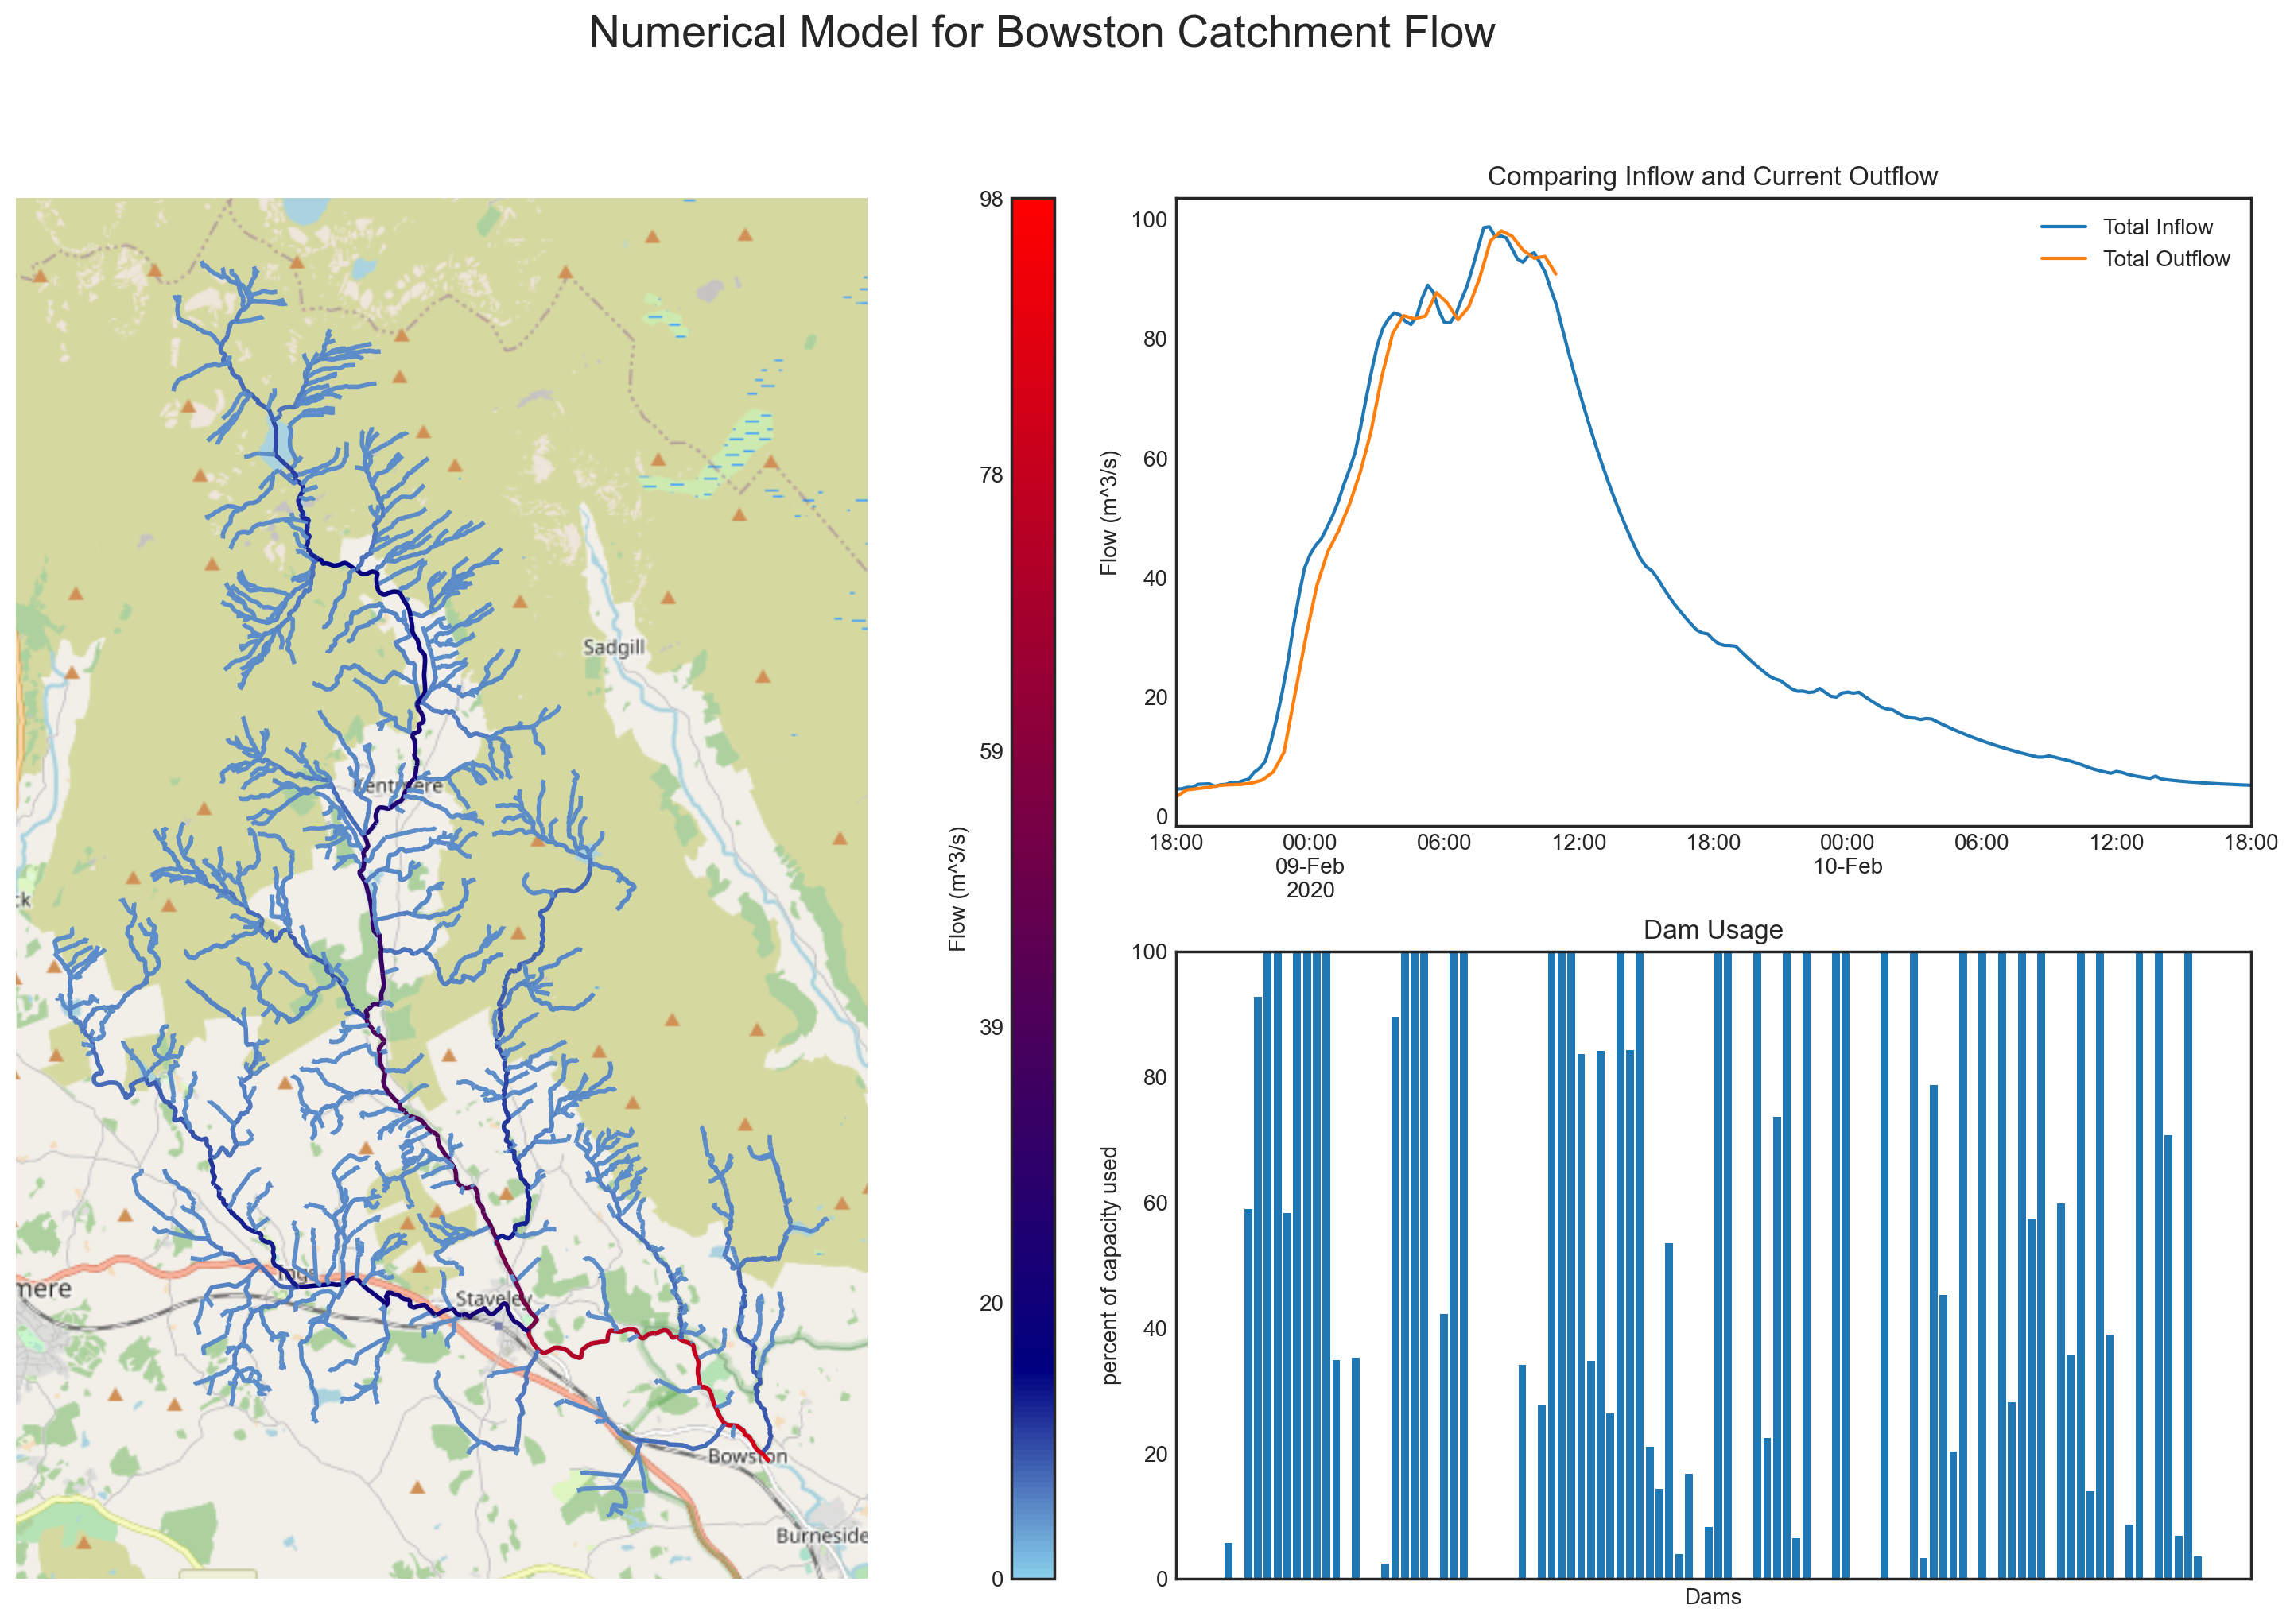

In [7]:
# example frame
plotfun(36)

In [10]:
# create frames to be used in the gif
images = []
for i in range(data.shape[1]):
    plotfun(i)
    plt.savefig("data/gif_images/network{i}.png".format(i=i), bbox_inches='tight')
    plt.close()
    print('\r'+str(i), end='\r')

# image filenames
filenames = []
for i in range(100):
    filenames.append('data/gif_images/network'+str(i)+'.png')

# load images and create a gif
images=[]
for filename in filenames:
    images.append(imageio.imread(filename))
    
    
imageio.mimsave('data/numerical_gif.gif', images)

Here is the created gif: <br>
<img src='data/numerical_gif.gif?2' width='8000' align='left'>